In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
sns.set_style("darkgrid")
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv',parse_dates=['trans_date'])


In [10]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [11]:
df_transactions.sort_values(by= ['customer_id','trans_date'], inplace=True) 
df_transactions.head()

,customer_id,trans_date,tran_amount
77247,CS1112,2011-06-15,56
89149,CS1112,2011-08-19,96
68206,CS1112,2011-10-02,60
36486,CS1112,2012-04-08,56
93074,CS1112,2012-06-24,52


In [12]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


Text(0, 0.5, '#Transaction')

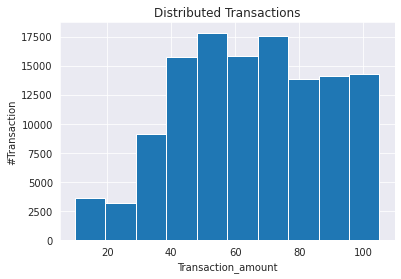

In [14]:
df_transactions['tran_amount'].hist()

plt.title('Distributed Transactions')
plt.xlabel('Transaction_amount')
plt.ylabel('#Transaction')


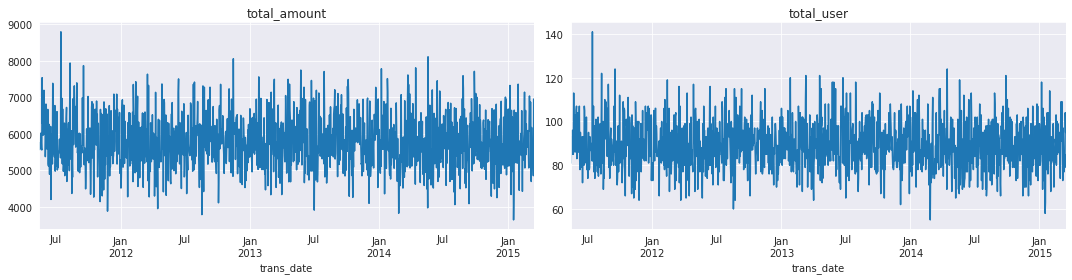

In [16]:
#Count user base date
fig, axes = plt.subplots(1,2, figsize=(15,4), tight_layout=True)
axes = axes.ravel()
df_mount_t = df_transactions.groupby('trans_date')['tran_amount'].sum().plot(title='total_amount',ax=axes[0])
df_user = df_transactions.groupby('trans_date')['customer_id'].count().plot(title='total_user',ax=axes[1])


In [17]:
## Reduce data period collect data since jan 2013 to 2015 03 16 
df_transactions= df_transactions[df_transactions['trans_date'].dt.year > 2012] 
df_transactions.shape

(71801, 3)

In [18]:
#Data Preparation
df_transactions['size_s'] =  df_transactions['tran_amount'].apply(lambda x : 1 if x < 40 else 0  )
df_transactions['size_m'] =  df_transactions['tran_amount'].apply(lambda x :  1 if x >= 40 and x < 80 else 0 )
df_transactions['size_l'] =  df_transactions['tran_amount'].apply(lambda x : 1 if x > 80 else 0) 
#df_transactions = df_transactions.drop(columns = ['pre_transacrion'])
df_transactions['pre_transaction']= df_transactions.groupby( ['customer_id'],as_index=False)['trans_date'].shift(1)
#df_transactions.rename(columns={'pre_visited':'pre_transaction'},inplace=True)
#df_transactions = df_transactions.drop(columns = ['pre_transacrion'])
df_transactions.head()

,customer_id,trans_date,tran_amount,size_s,size_m,size_l,pre_transaction
87839,CS1112,2013-03-01,105,0,0,1,NaT
42084,CS1112,2013-07-01,36,1,0,0,2013-03-01
74842,CS1112,2013-11-13,71,0,1,0,2013-07-01
26626,CS1112,2014-04-29,63,0,1,0,2013-11-13
17810,CS1112,2014-07-16,90,0,0,1,2014-04-29


In [ ]:
#df_transactions = df_transactions.drop(columns = ['pre_transaction'])

In [19]:
import datetime as dt
#dt.date(2017,12,27).weekday()
df_transactions['isweekend'] = df_transactions['trans_date'].dt.weekday.apply(lambda x : 1 if x >= 5 else 0  )
df_transactions['isweekday'] = df_transactions['trans_date'].dt.weekday.apply(lambda x : 0 if x >= 5 else 1  )

In [20]:
## sample check data 
df_transactions[df_transactions.customer_id == 'CS1112']

,customer_id,trans_date,tran_amount,size_s,size_m,size_l,pre_transaction,isweekend,isweekday
87839,CS1112,2013-03-01,105,0,0,1,NaT,0,1
42084,CS1112,2013-07-01,36,1,0,0,2013-03-01,0,1
74842,CS1112,2013-11-13,71,0,1,0,2013-07-01,0,1
26626,CS1112,2014-04-29,63,0,1,0,2013-11-13,0,1
17810,CS1112,2014-07-16,90,0,0,1,2014-04-29,0,1
31500,CS1112,2014-12-04,59,0,1,0,2014-07-16,0,1
5650,CS1112,2015-01-14,39,1,0,0,2014-12-04,0,1


In [30]:
## Date Diff data 
df_transactions['date_diff'] = -( df_transactions.pre_transaction - df_transactions.trans_date ).dt.days
df_transactions.head()

,customer_id,trans_date,tran_amount,size_s,size_m,size_l,pre_transaction,isweekend,isweekday,date_diff,recent
87839,CS1112,2013-03-01,105,0,0,1,NaT,0,1,NaN,746.0
42084,CS1112,2013-07-01,36,1,0,0,2013-03-01,0,1,122.0,624.0
74842,CS1112,2013-11-13,71,0,1,0,2013-07-01,0,1,135.0,489.0
26626,CS1112,2014-04-29,63,0,1,0,2013-11-13,0,1,167.0,322.0
17810,CS1112,2014-07-16,90,0,0,1,2014-04-29,0,1,78.0,244.0


In [22]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,size_s,size_m,size_l,pre_transaction,isweekend,isweekday,date_diff,recent
87839,CS1112,2013-03-01,105,0,0,1,NaT,0,1,NaN,746.0
42084,CS1112,2013-07-01,36,1,0,0,2013-03-01,0,1,122.0,624.0
74842,CS1112,2013-11-13,71,0,1,0,2013-07-01,0,1,135.0,489.0
26626,CS1112,2014-04-29,63,0,1,0,2013-11-13,0,1,167.0,322.0
17810,CS1112,2014-07-16,90,0,0,1,2014-04-29,0,1,78.0,244.0


In [23]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),               # Monetary Value           
                                                     'size_s' : 'sum',
                                                     'size_m': 'sum',
                                                     'size_l' : 'sum',
                                                     'date_diff': 'mean',    
                                                      'isweekend' : 'sum',
                                                      'isweekday' : 'sum' ,
                                                     'date_diff': 'std'
                                                     })
df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)
df_rfm.head()

,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday
customer_id,,,,,,,,,
CS1112,62.0,7,463,2,3,2,46.190908,0,7
CS1113,36.0,12,872,1,5,6,56.728220,2,10
CS1114,33.0,12,856,1,6,5,64.693262,3,9
CS1115,12.0,12,925,0,7,5,67.464604,2,10
CS1116,204.0,6,392,0,4,2,158.515930,1,5


In [24]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday
0,CS1112,62.0,7,463,2,3,2,46.190908,0,7
1,CS1113,36.0,12,872,1,5,6,56.728220,2,10
2,CS1114,33.0,12,856,1,6,5,64.693262,3,9
3,CS1115,12.0,12,925,0,7,5,67.464604,2,10
4,CS1116,204.0,6,392,0,4,2,158.515930,1,5


In [25]:
df_rfm['ticket_size'] = df_rfm['monetary_value'] / df_rfm['frequency']
df_rfm.head()

,customer_id,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday,ticket_size
0,CS1112,62.0,7,463,2,3,2,46.190908,0,7,66.142857
1,CS1113,36.0,12,872,1,5,6,56.728220,2,10,72.666667
2,CS1114,33.0,12,856,1,6,5,64.693262,3,9,71.333333
3,CS1115,12.0,12,925,0,7,5,67.464604,2,10,77.083333
4,CS1116,204.0,6,392,0,4,2,158.515930,1,5,65.333333


In [26]:
## **Calculating response rate**
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


<function matplotlib.pyplot.show>

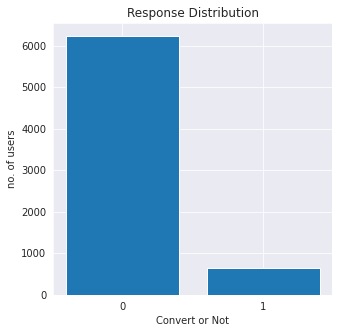

In [27]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show


In [28]:
# response_rate.head() #df_response
total_response =  pd.merge(df_rfm,df_response,left_on= 'customer_id',right_on = 'customer_id', how = 'inner')


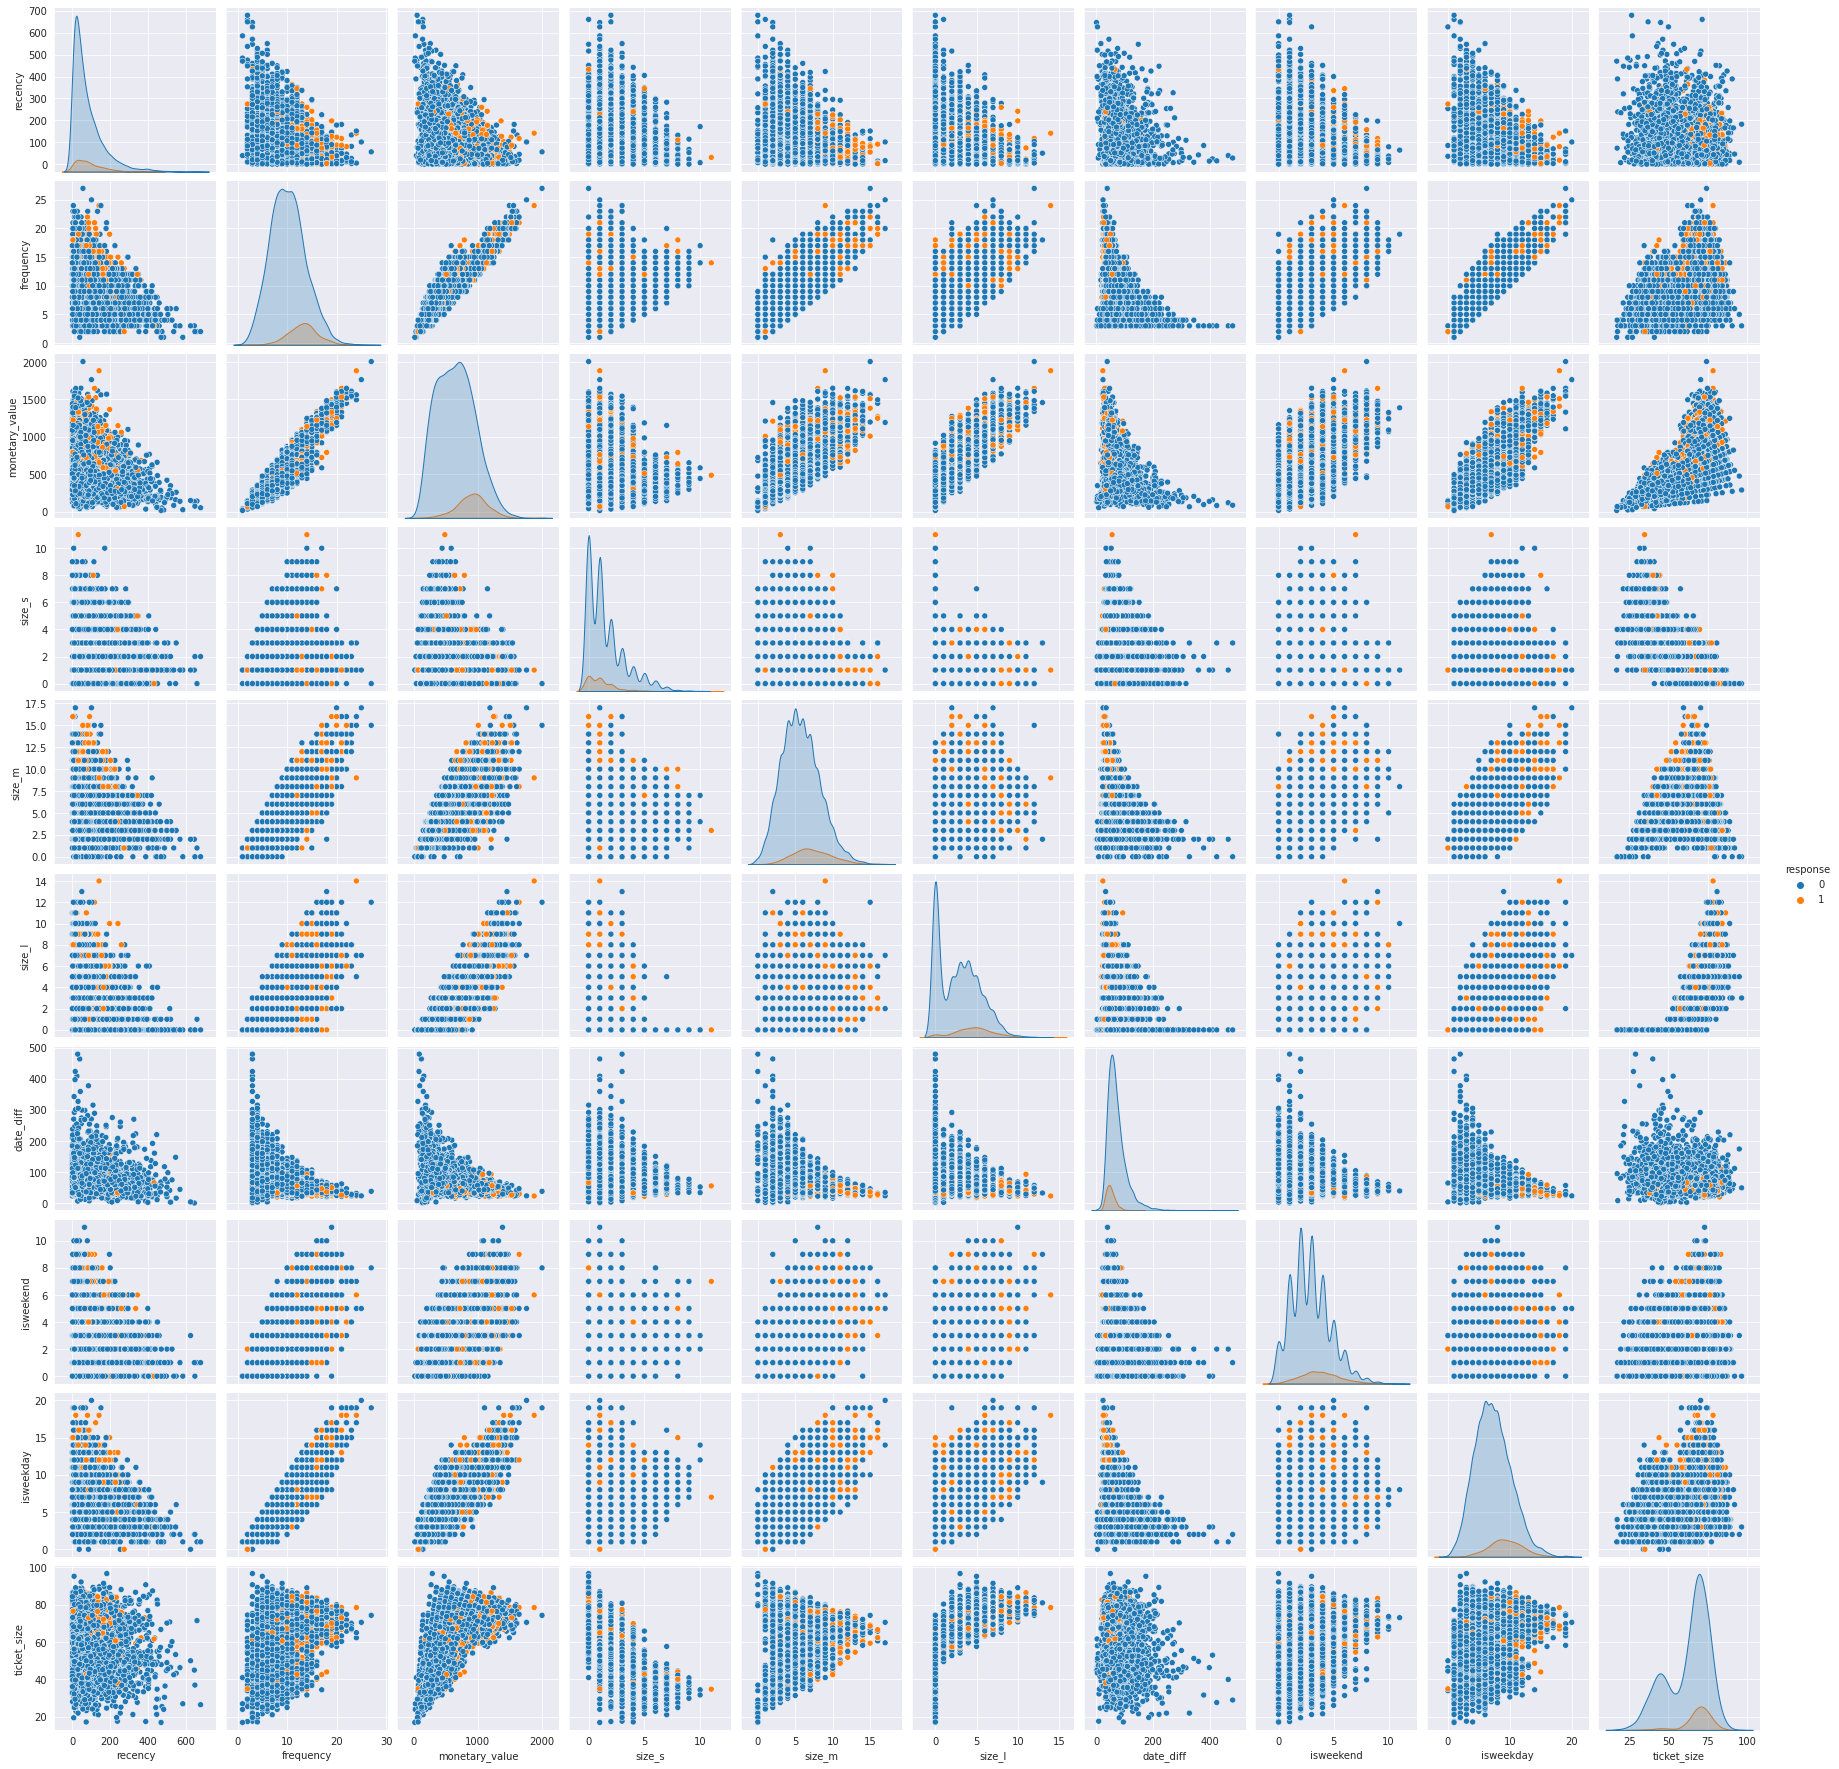

In [29]:
sns.pairplot(total_response,hue = 'response') 


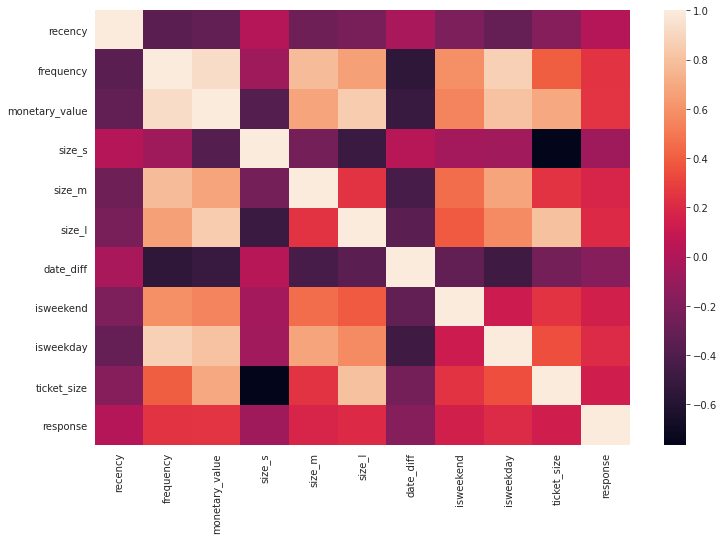

In [31]:
crr_t = total_response.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(crr_t)


In [32]:
# splite x,y  data
total_response.head()


,customer_id,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday,ticket_size,response
0,CS1112,62.0,7,463,2,3,2,46.190908,0,7,66.142857,0
1,CS1113,36.0,12,872,1,5,6,56.728220,2,10,72.666667,0
2,CS1114,33.0,12,856,1,6,5,64.693262,3,9,71.333333,1
3,CS1115,12.0,12,925,0,7,5,67.464604,2,10,77.083333,1
4,CS1116,204.0,6,392,0,4,2,158.515930,1,5,65.333333,1


In [33]:
# Under sampling 
X = total_response.iloc[:,1:-1]
y = total_response.iloc[:, -1]
list(X.shape)[1]
X_col = X.columns

In [34]:
## Feature selection 
total_response1 = total_response.copy()
total_response1.head()

,customer_id,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday,ticket_size,response
0,CS1112,62.0,7,463,2,3,2,46.190908,0,7,66.142857,0
1,CS1113,36.0,12,872,1,5,6,56.728220,2,10,72.666667,0
2,CS1114,33.0,12,856,1,6,5,64.693262,3,9,71.333333,1
3,CS1115,12.0,12,925,0,7,5,67.464604,2,10,77.083333,1
4,CS1116,204.0,6,392,0,4,2,158.515930,1,5,65.333333,1


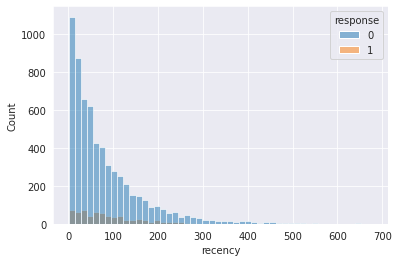

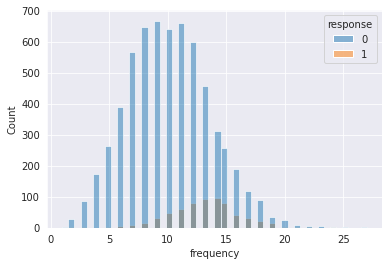

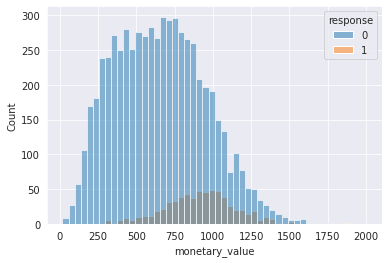

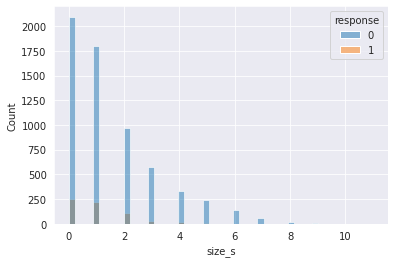

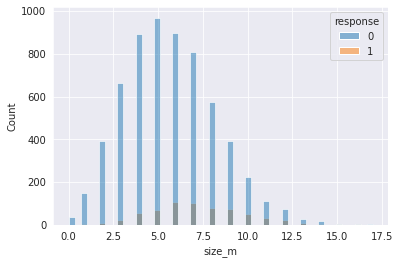

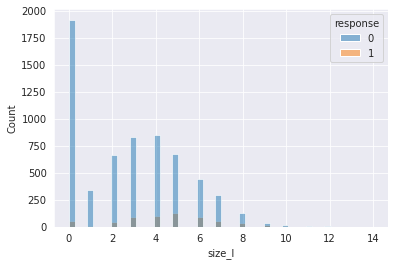

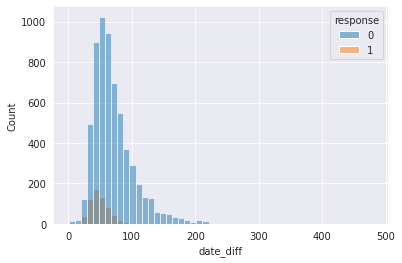

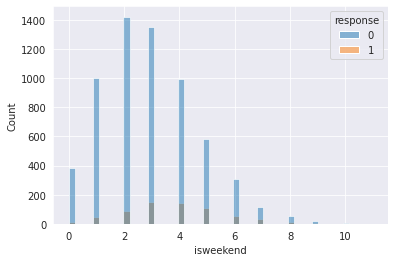

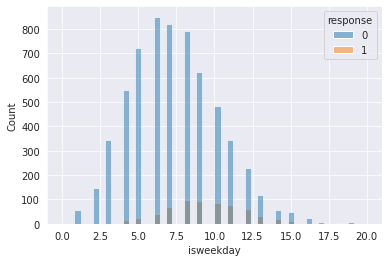

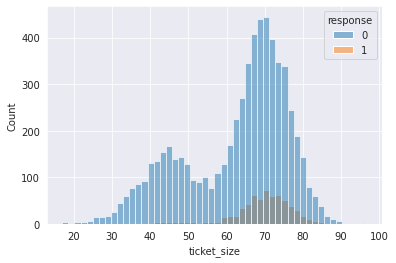

In [35]:
## Draw histrograme graph 
%matplotlib inline
for i in  total_response1.iloc[:,1:-1] :
  fig , ax = plt.subplots()
#response_model.hist( column='frequency', ax= ax, color = 'teal')
  #non_response_model.hist(column = i , ax=ax,)
  sns.histplot(data=total_response1, x= i,bins=50, hue='response')
  plt.show()
  #sns.histplot(data=df, x='avg_spend_24m',bins=50, hue='response', ax=axes[3])

In [36]:
# ### filter out some data ignore the campaign  with  ticket size below 60 and frequentcy  below 20 -35 
# fo_data =  total_response1[((total_response1['ticket_size'] >= 60) & (total_response1['frequency']>= 20))]
# fo_data.shape
# # fo_data_count =  fo_data.groupby(by='response').count().reset_index()
# # fo_data_count.plot.bar(x='response',y='frequency')

In [37]:
## Find histrigram with response and non-response campaign 
response_model = total_response1[total_response1.response == 1]
non_response_model = total_response1[total_response1.response == 0]
response_model.head()
non_response_model.head()

,customer_id,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday,ticket_size,response
0,CS1112,62.0,7,463,2,3,2,46.190908,0,7,66.142857,0
1,CS1113,36.0,12,872,1,5,6,56.728220,2,10,72.666667,0
5,CS1117,258.0,11,776,0,8,3,48.874556,5,6,70.545455,0
7,CS1119,12.0,10,747,1,4,5,54.991161,1,9,74.700000,0
8,CS1120,11.0,14,915,0,10,4,92.062827,3,11,65.357143,0


In [38]:
# Dataset and split data 
# X1 = total_response1.iloc[:,1:-1] #fo_data #total_response1
# y1 = total_response1.iloc[:,-1]
X1 = total_response1.iloc[:,1:-1]
y1 = total_response1.iloc[:,-1]

In [39]:
X1.head()

,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday,ticket_size
0,62.0,7,463,2,3,2,46.190908,0,7,66.142857
1,36.0,12,872,1,5,6,56.728220,2,10,72.666667
2,33.0,12,856,1,6,5,64.693262,3,9,71.333333
3,12.0,12,925,0,7,5,67.464604,2,10,77.083333
4,204.0,6,392,0,4,2,158.515930,1,5,65.333333


In [40]:
## fill null  
X1 =X1.replace(np.nan,0)

In [41]:
xc = X1.columns
xc

Index(['recency', 'frequency', 'monetary_value', 'size_s', 'size_m', 'size_l',
       'date_diff', 'isweekend', 'isweekday', 'ticket_size'],
      dtype='object')

In [42]:
## Train test splite data 

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=123)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 10)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 10)
Number transactions y_test dataset:  (2066,)


In [43]:
X_train.isnull().sum()

recency           0
frequency         0
monetary_value    0
size_s            0
size_m            0
size_l            0
date_diff         0
isweekend         0
isweekday         0
ticket_size       0
dtype: int64

# Under Sampling 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

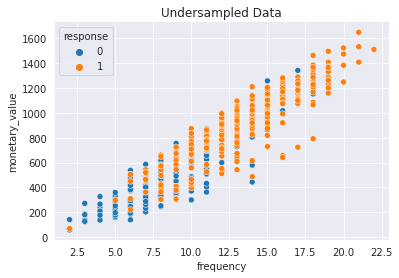

In [44]:
## handleing imbalance 
# Under Sampling 
rus = RandomUnderSampler(random_state=123)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency', 'frequency', 'monetary_value', 'size_s', 'size_m', 'size_l',
       'date_diff', 'isweekend', 'isweekday', 'ticket_size','response']


sns.scatterplot(data=df_undersampled, x='frequency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

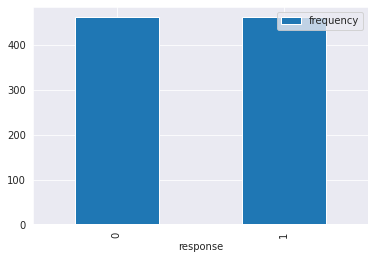

In [45]:
under_count =  df_undersampled.groupby(by='response').count().reset_index()
under_count.plot.bar(x='response',y='frequency')

# Over Sampling


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

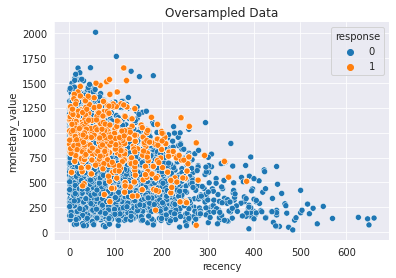

In [46]:
# Fixing imbalanced with Oversampling 
ros = RandomOverSampler(random_state=123)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'frequency', 'monetary_value', 'size_s', 'size_m', 'size_l',
       'date_diff', 'isweekend', 'isweekday', 'ticket_size','response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

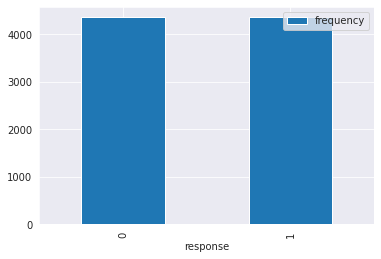

In [47]:
over_count =  df_oversampled.groupby(by='response').count().reset_index()
over_count.plot.bar(x='response',y='frequency')

# SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


FileNotFoundError: ignored

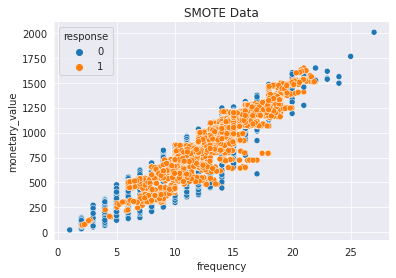

In [48]:
### SMOTE ###
sm = SMOTE(random_state=123)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns=  ['recency', 'frequency', 'monetary_value', 'size_s', 'size_m', 'size_l',
       'date_diff', 'isweekend', 'isweekday', 'ticket_size','response']

sns.scatterplot(data=df_SMOTE, x='frequency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")
plt.savefig('/content/drive/MyDrive/CRM_project/HW8/SMOTE_1.png',format = 'png',dpi = 150)


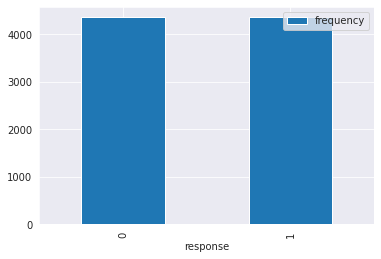

In [49]:
SMOTE_count =  df_SMOTE.groupby(by='response').count().reset_index()
SMOTE_count.plot.bar(x='response',y='frequency')

In [50]:
### Standardize training data 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train

array([[ 0.88087618, -0.66599813, -0.48504227, ..., -0.00291152,
        -0.81649364,  0.24748167],
       [-0.94602669, -1.48324382, -1.40569212, ..., -0.56402015,
        -1.48586004, -0.97336744],
       [ 0.9164652 , -0.12116767,  0.30455422, ..., -0.56402015,
         0.18755597,  1.05638783],
       ...,
       [-0.37660242,  0.42366279,  0.56010827, ...,  0.55819711,
         0.18755597,  0.57828434],
       [ 0.72665711, -0.66599813, -0.35071258, ..., -0.56402015,
        -0.48181044,  0.6313376 ],
       [ 0.37076694, -0.66599813, -0.24914623, ..., -0.56402015,
        -0.48181044,  0.92157013]])

## SMOTE-Token_link

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE-Token Data')

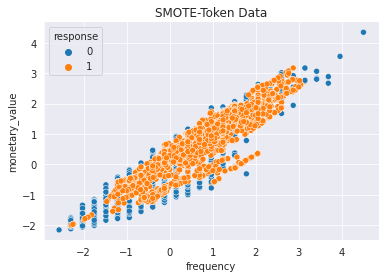

In [51]:
# Define SMOTE-Tomek Links
smt=SMOTETomek(random_state=123)
smt.fit(X_train, y_train)
X_SMOTET, y_SMOTET = smt.fit_sample(X_train, y_train)
df_SMOTET = pd.concat([pd.DataFrame(data=X_SMOTET),pd.DataFrame(data=y_SMOTET)], axis=1, sort=False)
df_SMOTET.columns=  ['recency', 'frequency', 'monetary_value', 'size_s', 'size_m', 'size_l',
       'date_diff', 'isweekend', 'isweekday', 'ticket_size','response']

sns.scatterplot(data=df_SMOTET, x='frequency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE-Token Data")

In [90]:
## cross validated 
def coss_valid( resampling ,model,x,y,title) :
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # Define pipeline
    pipeline=Pipeline(steps=[('r', resampling), ('m', model)])
    # Evaluate model
    scoring=['accuracy','precision_macro','recall_macro']
    scores = cross_validate(pipeline, x, y, scoring=scoring, cv=cv, n_jobs=-1,return_train_score = True)
    #print(scores)
    # summarize performance
    print('#'*10,title,'#'*10)
    print('Mean Accuracy Train: %.4f' % np.mean(scores['train_accuracy']))
    print('Max Accuracy Train: %.4f' % np.max(scores['train_accuracy']))
    print('Min Accuracy Train: %.4f' % np.min(scores['train_accuracy']))
    print('Mean precision Train: %.4f' % np.mean(scores['train_precision_macro']))
    print('Mean Recall Train: %.4f' % np.mean(scores['train_recall_macro']))
    print('--'*100)
    print('Mean Accuracy Test: %.4f' % np.mean(scores['test_accuracy']))
    print('Max Accuracy Test: %.4f' % np.max(scores['test_accuracy']))
    print('Min Accuracy Test: %.4f' % np.min(scores['test_accuracy']))
    print('Mean precision Test: %.4f' % np.mean(scores['test_precision_macro']))
    print('Mean Recall Test: %.4f' % np.mean(scores['test_recall_macro']))

In [53]:
# ## With SMOTE-Tomek Links method
# # Define model
# model=RandomForestClassifier(criterion='entropy')
# # Define SMOTE-Tomek Links
# resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# # Define pipeline
# pipeline=Pipeline(steps=[('r', resample), ('m', model)])
# # Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
# cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # Evaluate model
# scoring=['accuracy','precision_macro','recall_macro']
# scores = cross_validate(pipeline, X, Y, scoring=scoring, cv=cv, n_jobs=-1)
# # summarize performance
# print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
# print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
# print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

# Under sampling with Regression

In [58]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       461
           1       0.73      0.76      0.74       461

    accuracy                           0.74       922
   macro avg       0.74      0.74      0.74       922
weighted avg       0.74      0.74      0.74       922

test set
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1880
           1       0.19      0.69      0.29       186

    accuracy                           0.70      2066
   macro avg       0.57      0.69      0.55      2066
weighted avg       0.89      0.70      0.76      2066



In [59]:
## Cross validation 
resampling = RandomUnderSampler()
model = LogisticRegression(solver='liblinear', class_weight='balanced')
x= X1
y = y1
title = 'Coss validation undersampling-Regression'
coss_valid( resampling ,model,x,y,title) 

########## Coss validation undersampling-Regression ##########
Mean Accuracy Train: 0.6821
Max Accuracy Train: 0.7000
Min Accuracy Train: 0.6679
Mean precision Train: 0.5780
Mean Recall Train: 0.7122
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mean Accuracy Test: 0.6822
Max Accuracy Test: 0.7097
Min Accuracy Test: 0.6459
Mean precision Test: 0.5780
Mean Recall Test: 0.7117


#################### Regression Model with under sampling ####################
tn: 1317  fp: 563  fn: 58  tp:  128


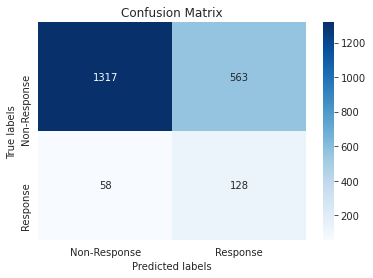

In [60]:
from sklearn.metrics import confusion_matrix

print('#'* 20 + " Regression Model with under sampling "+ '#'*20 )
tn, fp, fn, tp  = confusion_matrix(expected_y, predicted_y).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(expected_y, predicted_y)
cm
#plt.imshow(cm, cmap='binary')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'Blues');  #YlGn
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Response', 'Response'])
ax.yaxis.set_ticklabels(['Non-Response', 'Response']);

#################### Regression Model with under sampling ####################


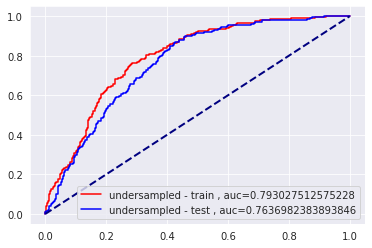

In [57]:
print('#'* 20 + " Regression Model with under sampling "+ '#'*20 )
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

# XGboost With Undersampling

In [61]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.748643
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.764682
[2]	validation_0-auc:0.76376
[3]	validation_0-auc:0.767883
[4]	validation_0-auc:0.766639
[5]	validation_0-auc:0.765797
[6]	validation_0-auc:0.766865
[7]	validation_0-auc:0.76921
[8]	validation_0-auc:0.769714
[9]	validation_0-auc:0.770274
[10]	validation_0-auc:0.773733
[11]	validation_0-auc:0.772881
[12]	validation_0-auc:0.774858
[13]	validation_0-auc:0.775836
[14]	validation_0-auc:0.775456
[15]	validation_0-auc:0.773411
[16]	validation_0-auc:0.772389
[17]	validation_0-auc:0.771613
[18]	validation_0-auc:0.771668
Stopping. Best iteration:
[13]	validation_0-auc:0.775836

training set
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       461
           1       0.73      0.81      0.77       461

    accuracy                           0.76       922
   macro avg       0.76      0.76      0.7

In [62]:
X1

,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday,ticket_size
0,62.0,7,463,2,3,2,46.190908,0,7,66.142857
1,36.0,12,872,1,5,6,56.728220,2,10,72.666667
2,33.0,12,856,1,6,5,64.693262,3,9,71.333333
3,12.0,12,925,0,7,5,67.464604,2,10,77.083333
4,204.0,6,392,0,4,2,158.515930,1,5,65.333333
...,...,...,...,...,...,...,...,...,...,...
6879,98.0,8,419,3,5,0,126.179766,0,8,52.375000
6880,262.0,8,295,5,3,0,60.913678,3,5,36.875000
6881,85.0,6,224,4,2,0,171.497230,0,6,37.333333
6882,258.0,5,126,5,0,0,39.382737,0,5,25.200000


In [63]:
## Cross validation 
resampling = RandomUnderSampler()
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
x= X1.values
y = y1
title = 'Coss validation undersampling-XG-boost'
coss_valid( resampling ,model,x,y,title) 

########## Coss validation undersampling-XG-boost ##########
Mean Accuracy Train: 0.6737
Max Accuracy Train: 0.6943
Min Accuracy Train: 0.6404
Mean precision Train: 0.5942
Mean Recall Train: 0.7645
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mean Accuracy Test: 0.6550
Max Accuracy Test: 0.6860
Min Accuracy Test: 0.6226
Mean precision Test: 0.5739
Mean Recall Test: 0.7071


#################### XGBoost with under sampling ####################
tn: 1248  fp: 632  fn: 40  tp:  146


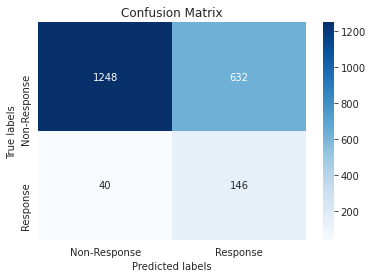

In [64]:
from sklearn.metrics import confusion_matrix
print('#'* 20 + " XGBoost with under sampling "+ '#'*20 )
tn, fp, fn, tp  = confusion_matrix(expected_y, predicted_y).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(expected_y, predicted_y)
cm
#plt.imshow(cm, cmap='binary')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'Blues');  #YlGn
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Response', 'Response'])
ax.yaxis.set_ticklabels(['Non-Response', 'Response']);

#################### XGBoost with under sampling ####################


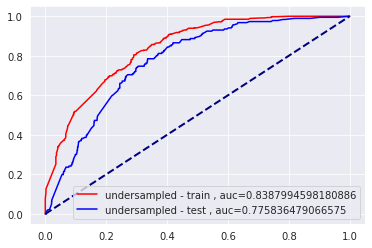

In [65]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))
print('#'* 20 + " XGBoost with under sampling "+ '#'*20 )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

# XGBoost model with SMOTE'

In [66]:
## SMOTE ###
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.709556
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.722056
[2]	validation_0-auc:0.722874
[3]	validation_0-auc:0.728523
[4]	validation_0-auc:0.73391
[5]	validation_0-auc:0.740381
[6]	validation_0-auc:0.744165
[7]	validation_0-auc:0.741787
[8]	validation_0-auc:0.745662
[9]	validation_0-auc:0.744363
[10]	validation_0-auc:0.73936
[11]	validation_0-auc:0.737546
[12]	validation_0-auc:0.740992
[13]	validation_0-auc:0.736262
Stopping. Best iteration:
[8]	validation_0-auc:0.745662

training set
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      4357
           1       0.76      0.87      0.81      4357

    accuracy                           0.80      8714
   macro avg       0.80      0.80      0.80      8714
weighted avg       0.80      0.80      0.80      8714

test set
              precision    recall  f1-score   support

           0       0.95      0.7

In [67]:
## Cross validation 
resampling = SMOTE()
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
x= X1.values
y = y1
title = 'Coss validation SMOTE-XG-boost'
coss_valid( resampling ,model,x,y,title) 

########## Coss validation SMOTE-XG-boost ##########
Mean Accuracy Train: 0.9034
Max Accuracy Train: 0.9075
Min Accuracy Train: 0.8996
Mean precision Train: 0.6800
Mean Recall Train: 0.5454
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mean Accuracy Test: 0.8973
Max Accuracy Test: 0.9055
Min Accuracy Test: 0.8824
Mean precision Test: 0.6054
Mean Recall Test: 0.5252


#################### Xgboost with SMOTE ####################
tn: 1363  fp: 517  fn: 73  tp:  113


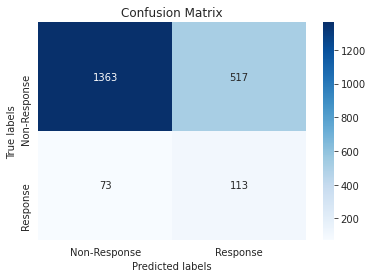

In [69]:
from sklearn.metrics import plot_confusion_matrix
print('#'* 20 + " Xgboost with SMOTE "+ '#'*20 )
tn, fp, fn, tp  = confusion_matrix(expected_y, predicted_y).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(expected_y, predicted_y)
cm
#plt.imshow(cm, cmap='binary')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'Blues');  #YlGn
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Response', 'Response'])
ax.yaxis.set_ticklabels(['Non-Response', 'Response']);


#################### Xgboost with SMOTE ####################


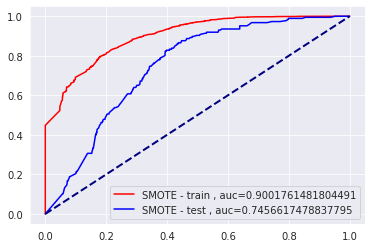

In [70]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))
print('#'* 20 + " Xgboost with SMOTE "+ '#'*20 )
y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()


In [ ]:
# ## Cross validation 
# resampling = SMOTE()
# model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
# x= X1.values
# y = y1
# title = 'Coss validation SMOTE-XG-boost'
# coss_valid( resampling ,model,x,y,title) 

## Regression with SMOTE ###


In [71]:
## REgression with SMOTE ###
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_smote = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_smote.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_smote.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      4357
           1       0.71      0.76      0.73      4357

    accuracy                           0.72      8714
   macro avg       0.72      0.72      0.72      8714
weighted avg       0.72      0.72      0.72      8714

test set
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1880
           1       0.19      0.70      0.30       186

    accuracy                           0.70      2066
   macro avg       0.57      0.70      0.55      2066
weighted avg       0.89      0.70      0.76      2066



In [ ]:
## Cross validation 
resampling = SMOTE()
model = LogisticRegression(solver='liblinear', class_weight='balanced')
x= X1.values
y = y1
title = 'Coss validation SMOTE-Regression'
coss_valid( resampling ,model,x,y,title) 

tn: 1320  fp: 560  fn: 55  tp:  131


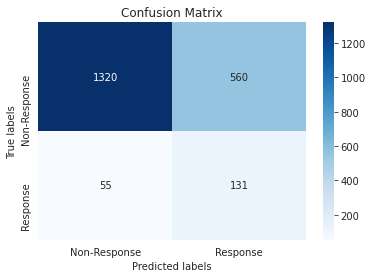

In [73]:
from sklearn.metrics import plot_confusion_matrix
tn, fp, fn, tp  = confusion_matrix(expected_y, predicted_y).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(expected_y, predicted_y)
cm
#plt.imshow(cm, cmap='binary')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'Blues');  #YlGn
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Response', 'Response'])
ax.yaxis.set_ticklabels(['Non-Response', 'Response']);

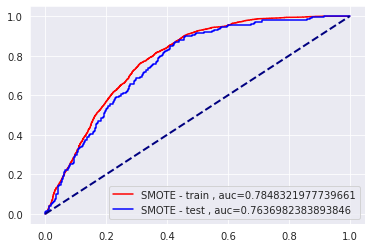

In [74]:
y_score_train = logreg_model_under.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()  


# y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
# fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
# auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
# plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

# y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
# fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
# auc_test = roc_auc_score(y_test, y_score_test[:,1])
# plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.legend(loc=4)
# plt.show()

In [75]:
## Regression over sampling 
print('logistic regression model - oversampking')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y_ov_tra = []
expected_y_ov_tra = []

logreg_model_under = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y_ov_tra.extend(predictions)
expected_y_ov_tra.extend(y_undersampled)
report_train = classification_report(expected_y_ov_tra, predicted_y_ov_tra)
print('training set with oversampling Regression ')
print(report_train) 

predicted_y_ov_tes = []
expected_y_ov_tes = []
predictions = logreg_model_under.predict(X_test)
predicted_y_ov_tes.extend(predictions)
expected_y_ov_tes.extend(y_test)
report_test = classification_report(expected_y_ov_tes, predicted_y_ov_tes)
print('test set with oversampling Regression ')
print(report_test) 

logistic regression model - oversampking
training set with oversampling Regression 
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       461
           1       0.73      0.76      0.74       461

    accuracy                           0.74       922
   macro avg       0.74      0.74      0.74       922
weighted avg       0.74      0.74      0.74       922

test set with oversampling Regression 
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1880
           1       0.18      0.69      0.29       186

    accuracy                           0.69      2066
   macro avg       0.57      0.69      0.55      2066
weighted avg       0.89      0.69      0.76      2066



In [76]:
# cross validation with  oversampling regression 
resampling = ros = RandomOverSampler()
model = LogisticRegression(solver='liblinear', class_weight='balanced')
x= X1.values
y = y1
title = 'Coss validation Over sampling-Regression'
coss_valid( resampling ,model,x,y,title) 

########## Coss validation Over sampling-Regression ##########
Mean Accuracy Train: 0.6829
Max Accuracy Train: 0.6908
Min Accuracy Train: 0.6762
Mean precision Train: 0.5797
Mean Recall Train: 0.7171
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mean Accuracy Test: 0.6811
Max Accuracy Test: 0.7054
Min Accuracy Test: 0.6444
Mean precision Test: 0.5784
Mean Recall Test: 0.7135


tn: 1304  fp: 576  fn: 57  tp:  129


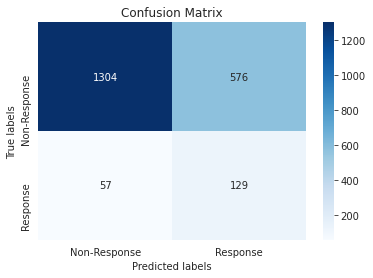

In [77]:
from sklearn.metrics import plot_confusion_matrix
tn, fp, fn, tp  = confusion_matrix(expected_y_ov_tes, predicted_y_ov_tes).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(expected_y_ov_tes, predicted_y_ov_tes)
cm
#plt.imshow(cm, cmap='binary')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'Blues');  #YlGn
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Response', 'Response'])
ax.yaxis.set_ticklabels(['Non-Response', 'Response']);

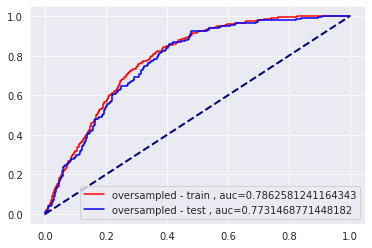

In [78]:
y_score_train = logreg_model_under.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

## XG-Boost with  Over sampling

In [79]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y_oxg_tr = []
expected_y_oxg_tr = []

xgb_model_under = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_oversampled)
predicted_y_oxg_tr.extend(predictions)
expected_y_oxg_tr.extend(y_oversampled)
report_train = classification_report(expected_y_oxg_tr, predicted_y_oxg_tr)
print('training set with oversampling xgboost')
print(report_train) 

predicted_y_oxg_test = []
expected_y_oxg_test = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y_oxg_test.extend(predictions)
expected_y_oxg_test.extend(y_test)
report_test = classification_report(expected_y_oxg_test, predicted_y_oxg_test)
print('test set with oversampling xgboost')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.766854
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.771298
[2]	validation_0-auc:0.767507
[3]	validation_0-auc:0.771351
[4]	validation_0-auc:0.777634
[5]	validation_0-auc:0.780278
[6]	validation_0-auc:0.781605
[7]	validation_0-auc:0.784835
[8]	validation_0-auc:0.78312
[9]	validation_0-auc:0.78406
[10]	validation_0-auc:0.784703
[11]	validation_0-auc:0.786237
[12]	validation_0-auc:0.786821
[13]	validation_0-auc:0.788427
[14]	validation_0-auc:0.788201
[15]	validation_0-auc:0.788827
[16]	validation_0-auc:0.787962
[17]	validation_0-auc:0.788574
[18]	validation_0-auc:0.789081
[19]	validation_0-auc:0.790387
[20]	validation_0-auc:0.790504
[21]	validation_0-auc:0.790078
[22]	validation_0-auc:0.789689
[23]	validation_0-auc:0.789548
[24]	validation_0-auc:0.790345
[25]	validation_0-auc:0.78953
Stopping. Best iteration:
[20]	validation_0-auc:0.790504

training set with oversampling xgboost
              prec

In [80]:
# cross validation with  oversampling regression 
resampling = RandomOverSampler()
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
x= X1.values
y = y1
title = 'Coss validation Over sampling-XG-boost'
coss_valid( resampling ,model,x,y,title) 

########## Coss validation Over sampling-XG-boost ##########
Mean Accuracy Train: 0.7028
Max Accuracy Train: 0.7120
Min Accuracy Train: 0.6917
Mean precision Train: 0.6027
Mean Recall Train: 0.7804
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mean Accuracy Test: 0.6807
Max Accuracy Test: 0.7282
Min Accuracy Test: 0.6386
Mean precision Test: 0.5775
Mean Recall Test: 0.7104


tn: 1228  fp: 652  fn: 33  tp:  153


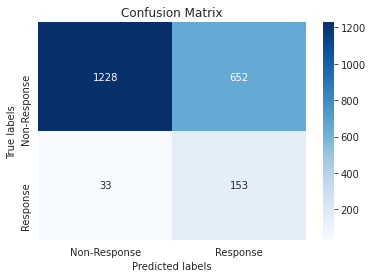

In [81]:
from sklearn.metrics import plot_confusion_matrix
tn, fp, fn, tp  = confusion_matrix(expected_y_oxg_test, predicted_y_oxg_test).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(expected_y_oxg_test, predicted_y_oxg_test)
cm
#plt.imshow(cm, cmap='binary')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'Blues');  #YlGn
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Response', 'Response'])
ax.yaxis.set_ticklabels(['Non-Response', 'Response']);

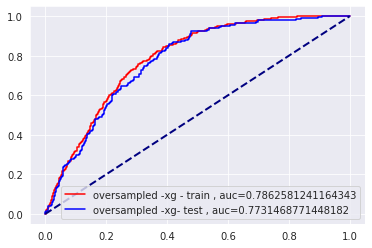

In [82]:
y_score_train = logreg_model_under.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled -xg - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled -xg- test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

## Regression with  SMOTE-Tokin Link

In [83]:
## REgression with SMOTE ###
print('logistic regression model - SMOTET')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y_train = []
expected_y_tain = []

logreg_model_smote = logreg.fit(X_SMOTET, y_SMOTET)
predictions = logreg_model_smote.predict(X_SMOTET)
predicted_y_train.extend(predictions)
expected_y_tain.extend(y_SMOTET)
report_train = classification_report(expected_y_tain, predicted_y_train)
print('training set')
print(report_train) 

predicted_y_smotet_test = []
expected_y_smotet_test = []
predictions = logreg_model_smote.predict(X_test)
predicted_y_smotet_test.extend(predictions)
expected_y_smotet_test.extend(y_test)
report_test = classification_report(expected_y_smotet_test, predicted_y_smotet_test)
print('test set')
print(report_test) 

logistic regression model - SMOTET
training set
              precision    recall  f1-score   support

           0       0.75      0.68      0.71      4340
           1       0.71      0.78      0.74      4340

    accuracy                           0.73      8680
   macro avg       0.73      0.73      0.73      8680
weighted avg       0.73      0.73      0.73      8680

test set
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1880
           1       0.00      0.00      0.00       186

    accuracy                           0.91      2066
   macro avg       0.45      0.50      0.48      2066
weighted avg       0.83      0.91      0.87      2066



In [84]:
resampling = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
model = LogisticRegression(solver='liblinear', class_weight='balanced')
x= X1.values
y = y1
title = 'Coss validation SMOTE-Tokin-Regression'
coss_valid( resampling ,model,x,y,title) 

########## Coss validation SMOTE-Tokin-Regression ##########
Mean Accuracy Train: 0.6800
Max Accuracy Train: 0.6878
Min Accuracy Train: 0.6717
Mean precision Train: 0.5790
Mean Recall Train: 0.7159
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mean Accuracy Test: 0.6783
Max Accuracy Test: 0.7108
Min Accuracy Test: 0.6430
Mean precision Test: 0.5775
Mean Recall Test: 0.7117


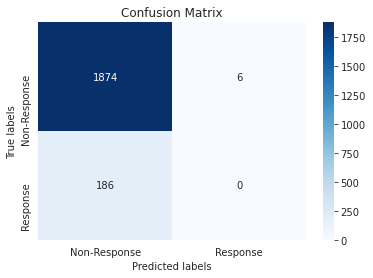

In [85]:
from sklearn.metrics import plot_confusion_matrix
tn, fp, fn, tp  = confusion_matrix(expected_y_smotet_test, predicted_y_smotet_test).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(expected_y_smotet_test, predicted_y_smotet_test)
cm
#plt.imshow(cm, cmap='binary')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'Blues');  #YlGn
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Response', 'Response'])
ax.yaxis.set_ticklabels(['Non-Response', 'Response']);

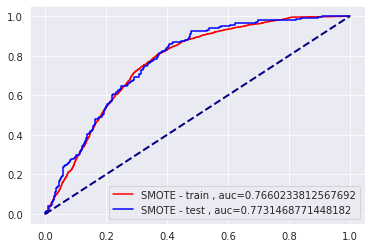

In [86]:
y_score_train = logreg_model_under.decision_function(X_SMOTET)
fpr_train, tpr_train, _ = roc_curve(y_SMOTET,  y_score_train)
auc_train = roc_auc_score(y_SMOTET, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()  


# y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
# fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
# auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
# plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

# y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
# fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
# auc_test = roc_auc_score(y_test, y_score_test[:,1])
# plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.legend(loc=4)
# plt.show()

## XG-boost SMOTET 

In [87]:
## SMOTET ###
print('XGBoost model - SMOTET')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y_smt2_train = []
expected_y_smt2_train = []

xgb_model_SMOTET = xgb_model.fit(X_SMOTET, y_SMOTET, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTET.predict(X_SMOTET)
predicted_y_smt2_train.extend(predictions)
expected_y_smt2_train.extend(y_SMOTET)
report_train = classification_report(expected_y_smt2_train, predicted_y_smt2_train)
print('training set')
print(report_train) 

predicted_y_smt2_test = []
expected_y_smt2_test = []
predictions = xgb_model_SMOTET.predict(X_test.values)
predicted_y_smt2_test.extend(predictions)
expected_y_smt2_test.extend(y_test)
report_test = classification_report(expected_y_smt2_test, predicted_y_smt2_test)
print('test set')
print(report_test) 

XGBoost model - SMOTET
[0]	validation_0-auc:0.5
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.5
[2]	validation_0-auc:0.5
[3]	validation_0-auc:0.5
[4]	validation_0-auc:0.497606
[5]	validation_0-auc:0.497606
Stopping. Best iteration:
[0]	validation_0-auc:0.5

training set
              precision    recall  f1-score   support

           0       0.85      0.58      0.69      4340
           1       0.68      0.90      0.78      4340

    accuracy                           0.74      8680
   macro avg       0.77      0.74      0.73      8680
weighted avg       0.77      0.74      0.73      8680

test set
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1880
           1       0.09      1.00      0.17       186

    accuracy                           0.09      2066
   macro avg       0.05      0.50      0.08      2066
weighted avg       0.01      0.09      0.01      2066



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
## Cross Validation
resampling = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
x= X1.values
y = y1
title = 'Coss validation SMOTE-Tomek XG_Boost'
coss_valid( resampling ,model,x,y,title) 

########## Coss validation SMOTE-Tomek XG_Boost ##########
Mean Accuracy Train: 0.9023
Max Accuracy Train: 0.9061
Min Accuracy Train: 0.8949
Mean precision Train: 0.6745
Mean Recall Train: 0.5523
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mean Accuracy Test: 0.8957
Max Accuracy Test: 0.9071
Min Accuracy Test: 0.8810
Mean precision Test: 0.6063
Mean Recall Test: 0.5308


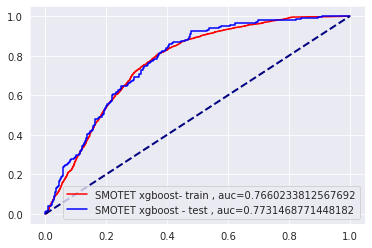

In [89]:
y_score_train = logreg_model_under.decision_function(X_SMOTET)
fpr_train, tpr_train, _ = roc_curve(y_SMOTET,  y_score_train)
auc_train = roc_auc_score(y_SMOTET, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTET xgboost- train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTET xgboost - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()  


# y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
# fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
# auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
# plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

# y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
# fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
# auc_test = roc_auc_score(y_test, y_score_test[:,1])
# plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.legend(loc=4)
# plt.show()